In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import scipy as sp
from scipy import stats

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
import sys
import gc
import copy
import glob

import tqdm
import itertools

import pymc

import sklearn as skl
from sklearn.utils import resample

# Truncation bias correction for exponential distribution

Before continuing lets first examine one potentially hazardous source of bias, turncation bias.

Formally, when one samples a distribution such that only samples which fall within a given range $[a,b]$ are retained, then the resulting sample effectively is taken from a truncated distribution rather than a full distribution.

E.g. if the full distribution $f(x)$ for a given observable is sampled such that only values of $x$ falling between $a$ and $b$ are retained, then one the truncated distribution is given by:
$$g(x)=\begin{cases} 
      \frac{f(x)}{\int_{a}^{b}{f(x)dx}} & x \in [a,b] \\
      0 & x \notin [a,b]
   \end{cases}$$

in the case of an exponential distribution this yields:

$$g(x,\lambda)=\frac{\lambda e^{-\lambda x}}{e^{-a\lambda}-e^{-b\lambda}};x\in[a,b]$$


Since we are gathering data from simulations of fixed duration and also at fixed sample intervals, we have an inherent limit on the resulting retention times that we can obtain. Specifically we cannot obtain a retention time that is longer than our simulation length, nor can we attain ones corresponding to times shorter than our sample interval length.

This means that we are artificially truncating the resulting distribution. The shorter our simulation length, the more the mean is biased to the left while the longer our sample interval is, the more the mean will be biased to the right.

Fortunately, for the exponential distribution, we can rederive our maximum likely hood estimator using the appropriate truncated exponential distribution. 

Now, if we assume that the probability of observing a given retention time in a simulation is independent of the retention times observed previously in the simulation. Then we can then express the likelyhood $L(\lambda)$ that a set of retention lengths $X={x_1,x_2,...,x_N}$ could be observed if they were sampled from a truncated distribution $g(x,\lambda)$ as the prodcut of $g(x,\lambda)$ over $X$:

$$L(\lambda)=\prod_{i=1}^{n}{g(x_i,\lambda)}$$

Without going into the full derivation, we find that the derivative of the log likelyhood with respect to $\lambda$ (reciporical of mean) is given by:

$$\frac{d}{d\lambda}\left( \log{L(\lambda)} \right)=
\frac{N}{\lambda}+N
\frac{a-b e^{(a-b)\lambda}}
{1-e^{(a-b)\lambda}}-N\langle x \rangle$$

where $a$ and $b$ are the sample interval and simulation length respectively, $N$ is the total count of the sampled distribution histogram for the simulation (i.e. total number of retention time intervals observed), and $\langle x \rangle$ is the mean of the observed retention time intervals for the simulation

In the case of multiple simulations, the right hand side can be summed using the appropriate N, b, and a for each simulation.

While there is no apparent closed form solution for the root of the above equation, it can be attained numerically fairly easily using sp.optimize.root. The reciprocal of the sample mean over all simulations (i.e. $\langle\langle x \rangle\rangle^{-1}$) would serve as a good choice for initial value.

We implement this below as a function which takes as an input a list simulation data where each entry is a list or tuple containing:
    1. the histogram distribution (bins,bincounts)
    2. the lower bound
    3. the upper bound
    
The function then returns the target function (derivative of log likelyhood of lambda) that can be optimized (e.g. fed into sp.optimize.root)

In [8]:
def genTruncatedExpEquations(dataList,verbose=False):
    XhistList,aList,bList=dataList
    aList=np.array(aList)
    bList=np.array(bList)
    
    finiteB=np.nonzero(np.isfinite(bList))
    nFiniteB=np.nonzero(finiteB==False)
    Xsums=np.array([np.sum(Xhist[0]*Xhist[1]) for Xhist in XhistList])
    Xcounts=np.array([np.sum(Xhist[1]) for Xhist in XhistList])
    if verbose:
        print 'truncation bounds:',
        print zip(aList,bList)
        print 'Histogram Mass Products:',
        print Xsums
        print 'Histogram Counts:',
        print Xcounts[finiteB]
        print 'finte upper bound list:',
        print finiteB
        print 'infinite upper bound list:',
        print nFiniteB
        print bList[finiteB]
    Nterm=lambda l: np.sum(Xcounts)/l
    finiteBterm=lambda l: np.sum(
        Xcounts[finiteB]* \
        (aList[finiteB]- \
             bList[finiteB]*np.exp((aList[finiteB]-bList[finiteB])*l))/ \
        (1-np.exp((aList[finiteB]-bList[finiteB])*l)))
    xSumTerm=np.sum(Xsums)
    if verbose:
        print 'combined sample mean: %.3f (lambda = %f)'%(
            xSumTerm/np.sum(Xcounts),np.sum(Xcounts)/xSumTerm)
    if np.sum(nFiniteB)>0:
        infBterm=lambda l: np.sum(Xcounts[nFiniteB]*aList[nFiniteB])
        optFun=lambda l: Nterm(l) + finiteBterm(l) + infBterm(l) - xSumTerm
    else:
        optFun=lambda l: Nterm(l) + finiteBterm(l) - xSumTerm
    return optFun

def fit_truncatedExp_to_dist(dataList,
                             verbose=False,
                             countsFirst=False,
                             returnFitData=False):
    fitFun=genTruncatedExpEquations(dataList,verbose=verbose)#,countsFirst)
    XhistList,aList,bList=dataList
    Xsums=np.array([np.sum(Xhist[0]*Xhist[1]) for Xhist in XhistList])
    if countsFirst:
        Xn=np.array([np.sum(Xhist[0]) for Xhist in XhistList])
    else:
        Xn=np.array([np.sum(Xhist[1]) for Xhist in XhistList])
    Xmean=1.*np.sum(Xsums)/np.sum(Xn)
    lFit=sp.optimize.root(fitFun,x0=1./Xmean)
    if returnFitData:
        return (lFit.x,lFit)
    else:
        return lFit.x

Before applying this directly to simulation data, lets have a look at how it behaves on some test distributions, constructed to model results of a typical all atom simulation.

To do so we select a lambda value for the true exponential distribution then use np.random.choice to create a corresponding sample after truncating to a lower bound of 1 (1 ns sample rate) and upper bound of 1000 (1 microsecond simulation length).

We add a pair of interaction widgets to allow interactive control of sample size and true mean.

Note that the results will be different each time the simulation updates because np.random.choice will generate a new sample every time.

In [11]:
@interact
def testModel(trueMean=widgets.FloatLogSlider(
                base=10,min=0,max=4,step=.1,value=2),
              nSamples=widgets.IntText(
                min=1,max=1000,value=10)):
    #trueMean=600.0
    trueLambda=1/trueMean
    nSamples=nSamples
    print "target sample count: %g"%nSamples
    tLower=.1
    tBin=1
    tUpper=200.0
    print 'Upper Bound: %f'%tUpper
    print 'Lower Bound: %f'%tLower 
    print 'Bin width: %f'%tBin
    binSet=np.arange(tLower,tUpper,tLower)
    normFactor=np.exp(-tLower*trueLambda)-np.exp(-tUpper*trueLambda)
    #normFactor
    pTestFun=lambda x: trueLambda*np.exp(-trueLambda*x)/normFactor
    tempProbs=pTestFun(binSet)#*np.exp(np.random.normal(0,.005,len(binSet)))
    tempProbs=tempProbs/np.sum(tempProbs)
    distSample=np.random.choice(binSet,size=nSamples,p=tempProbs)
    #tempDat=np.histogram(distSample,bins=np.concatenate([[0.],binSet]))
    #testDat=tempDat[0]
    
    binSet=np.arange(tBin,tUpper,tBin)
    tempDat=np.histogram(distSample,bins=np.concatenate([[0.],binSet]))
    testDat=tempDat[0]
    
    sampleMean=np.sum((binSet)*testDat/np.sum(testDat))
    print 'Total Sample Counts: %g'%np.sum(testDat)
    plt.plot(binSet[np.nonzero(testDat)],
             testDat[np.nonzero(testDat)],label='Data')
    plt.scatter(binSet[np.nonzero(testDat)],
                1.0*testDat[np.nonzero(testDat)],label='Data')
    trueVals=trueLambda*np.exp(-trueLambda*binSet[np.nonzero(testDat)])
    trueVals=trueVals/np.sum(trueVals)*nSamples
    plt.plot(binSet[np.nonzero(testDat)],
             trueVals,label='TrueDist')

    modelDat=1./sampleMean*np.exp(-(binSet[np.nonzero(testDat)])/sampleMean)
    modelDat=modelDat/np.sum(modelDat)
    plt.plot(binSet[np.nonzero(testDat)],
             modelDat*nSamples,label='BiasedModel')
    #plt.legend()
    #plt.show()
    print '--- --- --- ---'
    print 'true mean: %f; true Lambda: %f'%(1./trueLambda,trueLambda)
    print 'biased estimate of mean (sample mean): %f; biased lambda: %f'%(
        sampleMean,1./sampleMean)
    #genTruncatedExpEquations([(np.arange(5)+1,np)])

    testFun=genTruncatedExpEquations([[(binSet,testDat)],[tLower],[tUpper]])
    #testRange=np.linspace(485,497,11)
    print '--- test truncation fitting ---'
    optResult=sp.optimize.root(testFun,1./sampleMean,tol=1e-12)
    optLam=optResult.x
    print optResult
    print '---'
    testOpt=fit_truncatedExp_to_dist([[(binSet,testDat)],[tLower],[tUpper]],returnFitData=True)
    print testOpt
    print '--- --- ---'
    #print testFun(optLam)
    print 'corrected mean = %f (lambda = %f)'%(1./optLam,optLam)
    print '--- --- --- ---'
    #print testRange
    #print map(testFun,testRange)
    #plt.plot(1./testRange,map(testFun,1./testRange))
    #plt.grid()
    #plt.show()


    modelDat=optLam*np.exp(-(binSet[np.nonzero(testDat)])*optLam)
    modelDat=modelDat/np.sum(modelDat)
    print np.sum(modelDat)
    plt.plot(binSet[np.nonzero(testDat)],
             modelDat*nSamples,label='CorrectedModel')
    plt.legend()
    plt.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0TG9nU2xpZGVyKHZhbHVlPTIuMCwgZGVzY3JpcHRpb249dSd0cnVlTWVhbicpLCBJbnRUZXh0KHZhbHVlPTEwLCBkZXNjcmlwdGlvbj11J25TYW3igKY=


As we can see above the trunctation correction seems to yield a small improvement in general (although random chance involved in the sampling procedure can sometimes result in the biased model being better).

However, there is only a significant advantage when the true mean is close to either the sample interval or simulation length. When the true mean falls near to the mid point of those values (i.e. the sampling interval and simulation length), the biased and corrected result are nearly identical.

There is also one other important detail to consider. The data we constructed above sampled from the truncated exponential distribution with replacement. More specifically, the probability of selecting a given length from the truncated distribution was independent of the previously selected lenghts... Unfortunately, since our simulations are observing waiting / occupancy times over a fixed duration rather than until a fixed number of samples are attained, their results will not necessarily fit this criteria. This is because the proability of observing a given length changes after each successive observation. Specifically, if you are running the simulation for a duration, $t_{sim}$, and you have already observed observations with a total of $t_{obs}$ cumulative length, then the probability of seeing a length of time greater than $t_{sim} - t_{obs}$ is zero! That clearly violates the assumption that the probability of observing a length is independent of the other observed lengths.

Intuitively, we may expect that this sampling will underestimate the actual mean since the probability of seeing long lengths decreases continuously as the simulation progresses.

Lets check how this method fairs against a synthetic simulation data set.

This will be generated by repeatedly sampling the untruncated exponential distribution for a given lambda (reciprocal mean) and accumulating the total length sampled. When this accumulated length equas or exceeds the simulation length the process terminates. If the last length sampled would cause the accrued time to exceed simulation length, it will be truncated to the remaining simulation time. Also, any lengths sampled below the simulation 'frameRate' will be recorded as equal to the frame rate. This should match closely with our working model of the simulations being analyzed.

In [12]:
def gen_synthetic_sim_sample(l,tSim,frameRate):
    tAcc=0
    lower=frameRate
    upper=tSim
    binLocs=np.arange(0,upper+lower,lower)
    distData=[]
    while tAcc<tSim:
        upper=tSim-tAcc
        binSet=binLocs[binLocs<=upper]
        #probs=l*np.exp(-l*binSet)/(np.exp(-lower*l)-np.exp(-upper*l))
        #probs=probs/np.sum(probs)
        sVal=np.clip(np.random.exponential(1./l,1),lower,upper)
        distData.append(sVal)
        tAcc=tAcc+sVal+frameRate
    return np.concatenate(distData)

To match our current all atom simulation method, we will run for a total length of 2000 time units (2 $\mu s$ simulations) with a frameRate of .6 time units (2 $ps$ output frequency)

Our simulation results will be rebinned with bandwidth will be set to 1.0 (to match the 1 $ns$ output frequency from coarse grain as per our proceedure).

The simulation will be run over a range of distribution means from .3 to 4000. This should give us an idea of how well our truncation correction could be expected to fair. Each simulation will be run in quadruplicate.

In [13]:
simLen=2000.
frameRate=.6
binWidth=1.0
nReps=4
simMeans=10**np.linspace(np.log10(frameRate/2),np.log10(simLen*2),21)
#print simMeans

histBins=np.arange(0,simLen,binWidth)
histCenters=(histBins[:-1]+histBins[1:])/2.
print histCenters
simDataFrames=[]
for iMean,trueMean in enumerate(simMeans):
    print 'Generating data for Sim_%03g (Mean=%8.3f):'%(iMean,trueMean),
    for iRep in np.arange(nReps):
        print 'Rep_%02g'%iRep,
        rawSimData=gen_synthetic_sim_sample(frameRate=frameRate,l=1./trueMean,tSim=simLen)
        tempHist=np.histogram(rawSimData,histBins)
        nzInds=np.nonzero(tempHist[0])
        simHist=(histCenters[nzInds],tempHist[0][nzInds])
        nRows=len(simHist[0])
        tempFrame=pd.DataFrame({
            'SimID':['Sim_%03g'%iMean]*nRows,
            'Rep':['Rep_%02g'%iRep]*nRows,
            'WaitTime':simHist[0],
            'Count':simHist[1],
            'TrueMean':[trueMean]*nRows},
            columns=['SimID','Rep','WaitTime','Count','TrueMean'])
        simDataFrames.append(tempFrame)
    print ''
simDataFrame=pd.concat(simDataFrames)
del(simDataFrames)
gc.collect()
simDataFrame.head()

[5.0000e-01 1.5000e+00 2.5000e+00 ... 1.9965e+03 1.9975e+03 1.9985e+03]
Generating data for Sim_000 (Mean=   0.300): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_001 (Mean=   0.482): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_002 (Mean=   0.776): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_003 (Mean=   1.247): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_004 (Mean=   2.005): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_005 (Mean=   3.224): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_006 (Mean=   5.183): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_007 (Mean=   8.334): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_008 (Mean=  13.400): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_009 (Mean=  21.545): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_010 (Mean=  34.641): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_011 (Mean=  55.698): Rep_00 Rep_01 Rep_02 Rep_03 
Generating data for Sim_012 (Mean=  89.5

,SimID,Rep,WaitTime,Count,TrueMean
0,Sim_000,Rep_00,0.5,1554,0.3
1,Sim_000,Rep_00,1.5,55,0.3
2,Sim_000,Rep_00,2.5,2,0.3
0,Sim_000,Rep_01,0.5,1553,0.3
1,Sim_000,Rep_01,1.5,57,0.3


Now we apply both the naive sample mean estimate and truncation bias corrected estimate for each sampled simulation

In [22]:
groupingCols=['SimID','Rep']
simGroups=simDataFrame.groupby(groupingCols)

countCol='Count'
tCol='WaitTime'

histBins=np.arange(0,simLen,binWidth)
histCenters=(histBins[:-1]+histBins[1:])/2.

tLower=frameRate
tUpper=simLen

fitSummary=simGroups.apply(
        lambda grp: pd.Series({
            "Naive":np.sum(grp[countCol]*grp[tCol])/\
                np.sum(grp[countCol]),
            "BiasCorrected":1.0/fit_truncatedExp_to_dist(
                [[(grp[tCol],grp[countCol])],[tLower],[tUpper]])[0],
            "TrueMean":np.mean(grp['TrueMean'])
        })
    ).reset_index()

fitSummary.head()

,SimID,Rep,BiasCorrected,Naive,TrueMean
0,Sim_000,Rep_00,5.117006e-08,0.536623,0.300000
1,Sim_000,Rep_01,5.186964e-08,0.539058,0.300000
2,Sim_000,Rep_02,5.097360e-08,0.535936,0.300000
3,Sim_000,Rep_03,5.355439e-08,0.544832,0.300000
4,Sim_001,Rep_00,5.229111e-02,0.652291,0.482357


Lets make a plot of our results. We will use a log-log scale since the values vary over a fairly wide range.

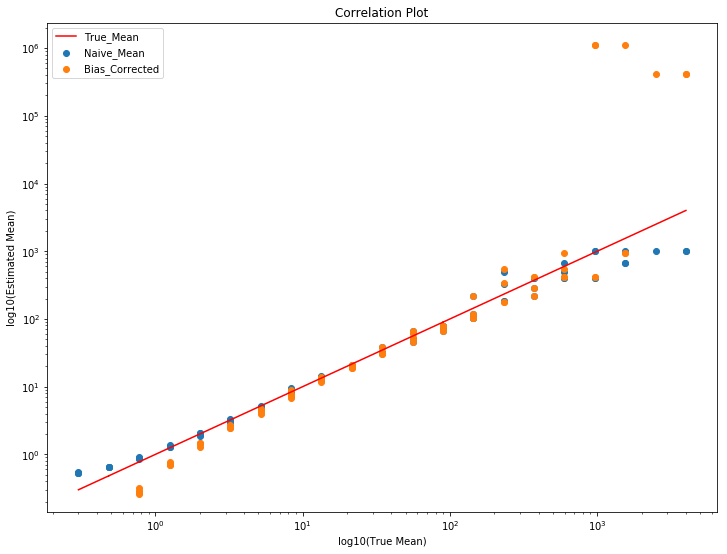

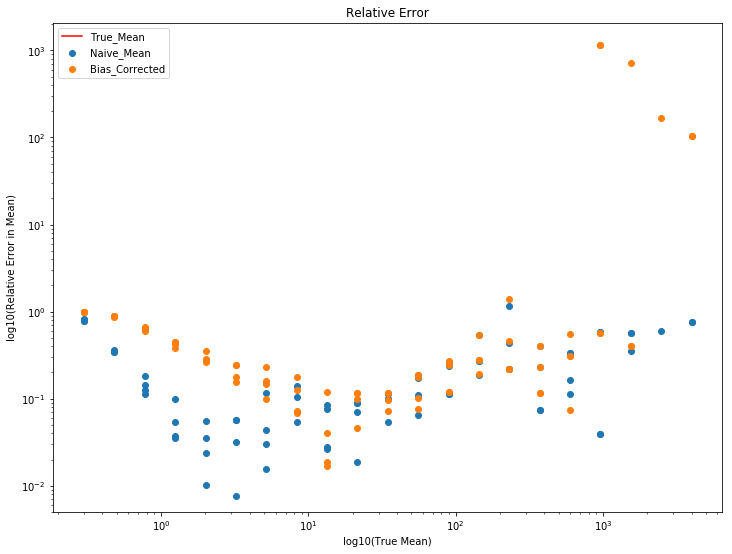

In [33]:
plt.figure(figsize=(12,9))
plt.scatter(fitSummary.TrueMean,fitSummary.Naive,
            label='Naive_Mean')
plt.scatter(fitSummary.TrueMean,fitSummary.BiasCorrected,
            label='Bias_Corrected')
plt.plot(fitSummary.TrueMean,fitSummary.TrueMean,c='r',
         label='True_Mean')
plt.title('Correlation Plot')
plt.xlabel("log10(True Mean)")
plt.ylabel("log10(Estimated Mean)")
plt.legend()
plt.loglog()
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(fitSummary.TrueMean,
            (np.abs(fitSummary.Naive-fitSummary.TrueMean))/fitSummary.TrueMean,
            label='Naive_Mean')
plt.scatter(fitSummary.TrueMean,
            (np.abs(fitSummary.BiasCorrected-fitSummary.TrueMean))/fitSummary.TrueMean,
            label='Bias_Corrected')
plt.plot(fitSummary.TrueMean,fitSummary.TrueMean-fitSummary.TrueMean,c='r',
         label='True_Mean')
plt.title('Relative Error')
plt.xlabel("log10(True Mean)")
plt.ylabel("log10(Relative Error in Mean)")
plt.legend()
plt.loglog()
plt.show()

From inspection, the correlation plot seems decent for both naive and corrected, however, the relative error plot shows quite clearly that the bias correction is actually worse than the naive mean. This is particularly true near the extremes, which is where we should expect the truncation correction to be the most effective. Therefore, in this case, the truncated distribution is not an appropriate model / bias correction method.